1. 프로젝트 선정 동기
> 노인 발화 음성 인식

현재 우리 사회는 고령화가 급속하게 진행되고 있으며 기술의 발전에 따른 서비스의 디지털 전환도 동시에 이루어지고 있다.\
때문에 많은 서비스들이 디지털화되면서 디지털 서비스 사용에 미숙한 고령층들이 어려움을 겪고 있다. 키오스크 주문 방식을 사용하는 매장이 늘어남에 따라 키오스크 작동이 미숙한 고령 인구가 카운터로 향하는 모습은 주변에서 흔히 볼 수 있는 실정이다. 따라서 노인 음성이 주가 되는 음성 인식 모델을 만들고 이를 키오스크에 적용하여 노인의 디지털 서비스 접근성을 높이고자 한다.


2. 데이터 셋
> 명령어 음성(노인남여)

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=94

다양한 명령어 발화 중 키오스크에 관한 데이터 셋인 (키오스크_원천_1_명령어(노인))을 사용하였고\
해당 데이터 43669개 중 학습의 효율과 모델의 다양성 및 학습 비용을 고려하여 7719개를 랜덤 추출하여 사용하였다.\
7719개의 데이터 중 6315개는 train data로, 702개는 validation data로, 나머지 702개는 test data로 활용하여 8:1:1의 비율을 맞추어 사용하였다.


3. 사용 모델 정보
> KoSpeech

Deep Speech2, LAS, joint CTC-Attention LAS, RNN-T, Speech Transformer, Jasper, Conformer의 모델을 기반으로 만든 KoSpeech 오픈 소스 모델을 이용하였다.\
각 모델을 단독으로 사용하거나, 혹은 앙상블하여 사용할 수도 있도록 내부의 함수로서 지원한다. 기존의 DNN-HNN 모델에서는 한국어의 복잡한 형성 원리를 처리하는 과정에서 어려움이 존재했는데, End-to-End 모델에서는 그러한 처리가 크게 필요치 않아 이점이 있었다.\
 본 노트에서 다룰 내용은 코드를 기준으로 살펴 본 모델의 전반적인 work flow와 핵심 기술 및 이론에 관한 내용이다.

## 초기 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/koojahyeob/Deep_Learning_Project '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT' #이거 저희 git 맞춰서 수정해야 합니다

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install hydra-core omegaconf #설치 후 Kernel 재부팅 해야하므로 따로 분리해 둠

In [2]:
#학습을 위한 필수 라이브러리 설치
#다른 라이브러리와 한번에 설치하면 오류 발생 위험이 있어서 따로 설치
!pip install hydra-core omegaconf astropy
!pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.9 MB/s eta 0:00:00


In [3]:
#kospeech가 사용 한 라이브러리 버전을 맞추기 위해 파이썬 버전 변경
!curl https://pyenv.run | bash
!pyenv install 3.10.0
!pyenv global 3.10.0
!python -m pip install --upgrade pip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   270  100   270    0     0   1531      0 --:--:-- --:--:-- --:--:--  1525
Cloning into '/root/.pyenv'...
remote: Enumerating objects: 1254, done.
remote: Counting objects: 100% (1254/1254), done.
remote: Compressing objects: 100% (700/700), done.
remote: Total 1254 (delta 735), reused 708 (delta 421), pack-reused 0
Receiving objects: 100% (1254/1254), 623.52 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (735/735), done.
Cloning into '/root/.pyenv/plugins/pyenv-doctor'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 5 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 38.72 KiB | 1.94 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Cloning into '/root/.pyenv/plugins/pyenv-update'...
remote: Enumera

In [ ]:
#kospeech에서 명시한 필수 라이브러리 설치
!pip install -r "/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/requirements_cssiri.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.5/377.5 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 41.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Prepa

>텍스트 데이터 전처리

해당 모델에서는 내부적으로 Kspon 데이터에 대한 텍스트 데이터 전처리를 지원한다. 해당 과정은 음성 데이터 정보를 담은 Json 파일을 통해 음성 데이터의 이름, 전사 정보를 가져오고 해당 전사 정보로부터 각 문자의 빈도수를 기준으로 나열한 vocab.csv를 만들어 벡터화한 정보를 바탕으로 transcript.txt를 생성한다. 우리 팀은 관리의 용이함과 호환성 확보 및 경로 에러를 피하기 위해 괄호나 문장 부호를 제거한 전사 정보와 음성 데이터 이름을 담은 train.txt을 별도로 만들고 이를 활용하여 전처리를 진행하였다.

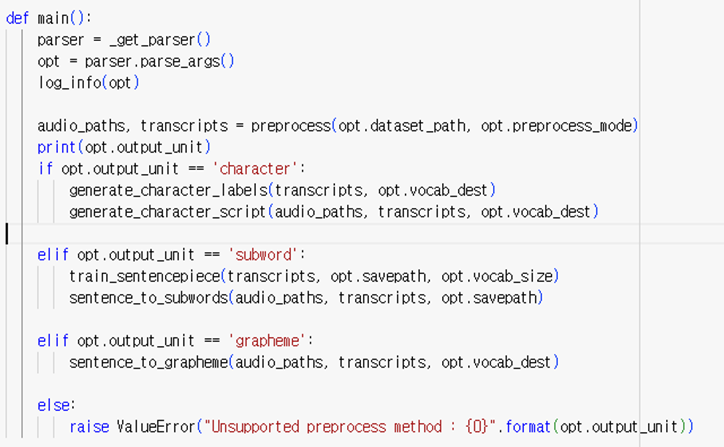

###Json 파일 내용

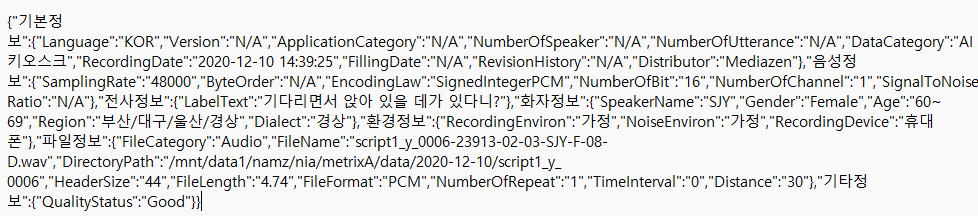

###transcript.txt 내용

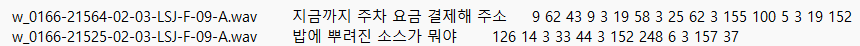

# train.txt 스크립트 만들기

In [4]:
#데이터 및 train.txt 경로 설정
audio_dir = "/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/audio_data"
meta_dir = "/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/label_dataset"
output_file = "/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/train.txt"

In [5]:
import json
import os
import re

def rule(x):
    # 괄호
    a = re.compile(r'\([^)]*\)')
    # 문장 부호
    b = re.compile('[^가-힣0-9 ]')
    x = re.sub(pattern=a, repl='', string= x)
    x = re.sub(pattern=b, repl='', string= x)
    return x

전사 정보에서 괄호와 문장 부호를 제거하여 텍스트 데이터에 노이즈를 제거한다.

In [6]:
cnt = 0
with open(output_file, "w", encoding='UTF-8') as out_file:
    for file in os.listdir(audio_dir):
        cnt += 1
        audio_path = os.path.join(audio_dir, file)
        base_name = os.path.basename(file).split('.')[0]
        meta_path = os.path.join(meta_dir, base_name + '.json')

        try:
            with open(meta_path, 'r', encoding='UTF-8') as f:
                json_data = json.load(f)
                reading = json_data["전사정보"]["LabelText"]

            reading = rule(reading)

            # 파일 이름과 텍스트를 탭으로 구분하여 저장
            out_file.write(f'{file}\t{reading}\n')

        except Exception as e:
            out_file.write("------error    error--------\n")
            print(f"Error processing file {file}: {e}")


print("Processing complete. Total files processed:", cnt)

Processing complete. Total files processed: 6314


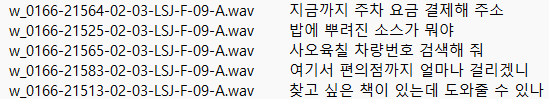

##preprocess.sh

preprocess.sh를 통해 preprocess_mode를 임의로 설정할 수 있다. output_unit은 character, subword, grapheme으로 토큰화 방식을 선택할 수 있고, preprocess_mode는 음소(phonetic)(ex. 칠 십 퍼센트)와 자소(spelling)(ex. 70%)모드를 선택할 수 있다.\
우리 팀은 character 방식을 사용하기로 하였다.

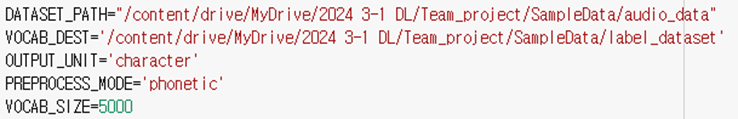

In [ ]:
#텍스트 전처리
%cd "/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT"
!python "/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/dataset/kspon/main.py" --dataset_path "/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/label_dataset" --vocab_dest "/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/vocab" --output_unit "character" --preprocess_mode 'phonetic'

/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT
Dataset Path : /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/label_dataset
Vocab Destination : /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/vocab
Save Path : ./data
Output-Unit : character
Preprocess Mode : phonetic
preprocess started..
성공
character
create_char_labels started..
create_script started..


preprocess 함수에서 character.py 파일의 함수를 호출하여 character와 index간 매핑 사전을 만든다. 본 프로젝트에서는 등장 빈도수가 3개 미만인 경우 사전에서 제외하여 발화 가능성이 낮은 문자를 예측하는 경우를 배제하기 위해 상위 404개의 글자를 선택해 transcript를 만들었다.

In [7]:
import pandas as pd

# CSV 파일 경로 설정
csv_path = '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/vocab/cssiri_character_vocabs.csv'

# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 행 개수 출력
print(f'The file has {len(df)} rows.')

The file has 405 rows.


##오디오 전처리

core.py에는 오디오 데이터를 로드하여 프레이밍, 파워 스펙트럼 추출, silent frame 제거, Root Mean Square 계산 등의 함수가 구현되어 있으며 feature.py에는 transformation 함수들이 구현되어 있다. transformation 방법은 4개로 Mel spectrogram, MFCC, spectrogram, filterbank가 있었으며 parser.py의 transform_method 인자를 통해 설정할 수 있었다.

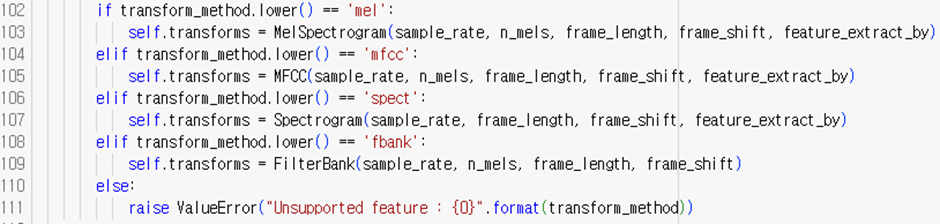

image.png

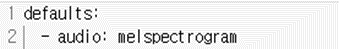

눈여겨볼 점은 해당 모델에서 데이터 증강 기법으로 선택한 ‘Spec Augmentation’이다. 오디오를 오디오 신호 자체 상태가 아니라 오디오 신호로부터 추출된 특성을 담고 있는 주파수 대 시간 그래프인 Spectrogram 상에서 시간 혹은 주파수를 마스킹하여 일반화 성능을 높이는 증강 기법이다. 본 프로젝트에서는 Mel spectrogram의 형태로 transformation한 텐서 형태의 feature을 이용해 Spec augmentation을 수행하고 있는 모습이다.


image.png

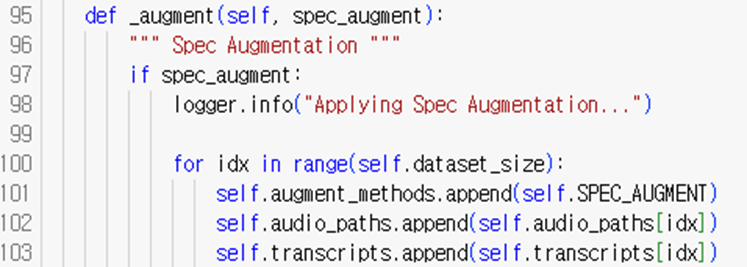

모든 데이터에 대하여 증강을 적용하고 이를 원본 데이터에 붙여넣기 때문에 학습 시에 데이터의 양이 본래 train 데이터의 개수에 비하여 두 배가 된 모습을 볼 수 있다.

##모델 구조
**파일 경로 : bin/kospeech/models/deepspeech2/model.py**

* 본 프로젝트에서 사용할 모델 아키텍처는 DeepSpeech2 모델 기반이다. 이 모델에서 가장 핵심이라고 볼 수 있는 부분은 CTC(Connectionist Temporal Classification) 손실 함수를 사용한다는 것이다.

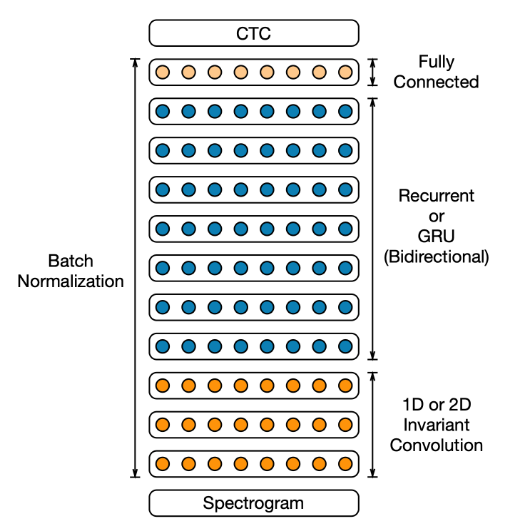

* DeepSpeech2 모델 구조
    - **입력 처리**:
        - 입력 오디오를 파워 스펙트로그램 형태로 변환한다. 이는 스펙트로그램의 한 종류로 주파수 성분의 에너지를 나타낸다. 이는 일반적인 스펙트로그램보다 음성의 강도 변화를 더욱 명확하게 분석한다.
    - **합성곱 층 (Convolutional Layers)**
        - 몇 개의 합성곱 층을 통해 입력 스펙트로그램의 저수준 특징을 추출한다. 이는 입력 데이터의 차원을 줄이고, 더 높은 수준의 특징을 인코더로 전달한다.
    - **양방향 RNN 층 (Bidirectional RNN Layers)**
        - 여러 층의 양방향 RNN (주로 GRU 또는 LSTM)을 사용하여 시간 순서와 역순으로 데이터를 처리한다. 이는 각각의 시간 단계에서 앞뒤 문맥 정보를 모두 활용할 수 있게끔 한다.
        - 각 RNN 층은 숨겨진 상태 크기와 드롭아웃 등의 하이퍼파라미터로 구성된다.
    - **완전 연결 층 (Fully Connected Layers)**
        - RNN 층의 출력을 하나 이상의 완전 연결 층으로 변환하여 최종 출력 차원을 줄이는 역할을 한다.
    - **출력층 (Output Layer)**
        - 최종 출력은 각 시간 단계에서의 문자 확률을 나타내는 소프트맥스 층으로 구성된다. 여기에는 문자와 블랭크 토큰이 포함된다. 또한 해당 결과를 통해 CTC loss를 계산한 뒤 역전파를 수행해 모델을 학습합니다.
    - **배치 정규화 (Batch Normalization)**
        - 선형변환과 활성함수가 연이어 나타나는 모든 곳에 배치 정규화를 추가하였다. 이는 모델을 구성할 때 바이어스 항(b)을 생략한 이유로 배치 정규화를 수행하면 이동평균을 빼주는 과정 때문에 바이어스 효과가 상쇄되기 때문이다.
    
    여기서 DeepSpeech2 모델의 핵심은 CTC loss function인데 이 역할은 아래와 같다.
    
    1. **정렬 문제 해결**: 입력 시퀀스와 출력 시퀀스의 길이가 다를 때, 정렬 문제를 해준다. CTC는 다양한 가능한 정렬 경로의 확률을 계산하고, 이를 통해 최종 손실을 계산한다.
    2. **블랭크 토큰 사용**: 블랭크 토큰을 도입하여 출력 시퀀스에서 특정 위치가 비어있음을 나타낼 수 있다. 이는 가변 길이의 입력과 출력을 효과적으로 정렬하는 데 도움이 된다.

##Optimizer
**파일 경로 : configs/train/ds2_train.yaml**

* configs/train/ds2_train.yaml 파일을 확인해 보면, adam optimizer를 이용하고 있음을 확인할 수 있는데, 그에 더해서 init_lr, final_lr 등과 같은 알 수 없는 인자들이 존재한다.

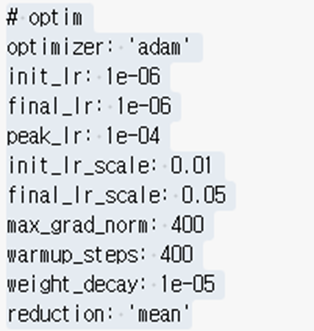

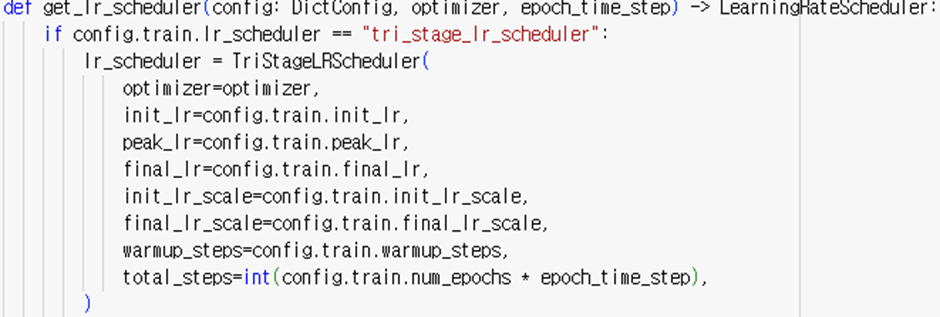


이들은 kospeech 모델에서 차용한 learning rate 스케쥴링 기법을 구현하기 위한 변수들인데, lr이 증가하는 warm up, lr이 멈춰 있는 hold, lr이 감소하는 decay 구간으로 나눌 수 있다. 각 변수의 의미는 다음과 같다.

- 학습률이 init_lr에서 시작하여
- peak_lr까지 warmup_steps의 횟수동안 warmup_rate의 비율로 증가하다가
- hold_steps의 횟수만큼 학습률을 유지하고
- final_lr까지 decay_steps의 횟수동안 decay_factor의 비율로 내려온다.

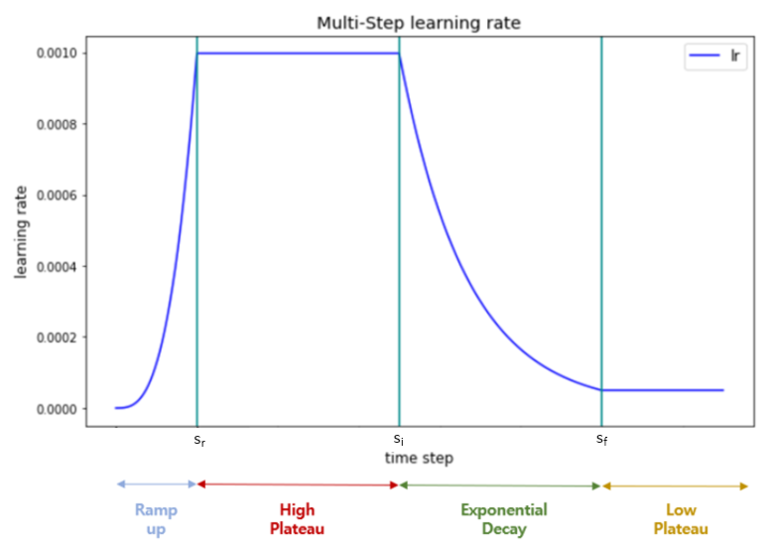

학습 결과에서 이러한 scheduling을 확인할 수 있다.

In [ ]:
#학습
!python "/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/bin/main.py" model=ds2 train=ds2_train train.dataset_path="/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/audio_data"

/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/bin/main.py:158: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path=os.path.join('..', "configs"), config_name="train")
sys:1: UserWarning: 
'audio/fbank' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
sys:1: UserWarning: 
'model/ds2' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will be removed in Hydra 1.2.
See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/automatic_schema_matching for migration instructions.
sys:1: UserWarning: 
'train/ds2_train' is validated against ConfigStore schema with the same name.
This behavior is deprecated in Hydra 1.1 and will b

       loss       cer
0  0.000703  2.202169
1  0.000334  1.574777
2  0.000294  1.348064
3  0.000243  1.211598
4  0.000182  1.104302


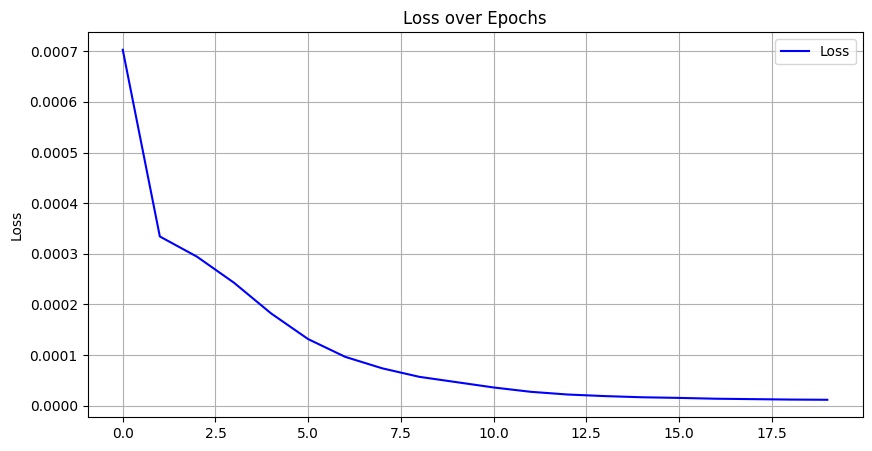

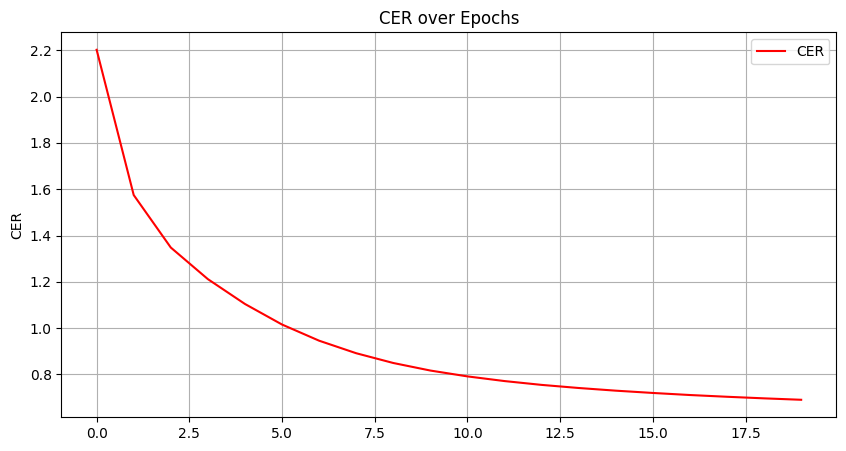

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# eval.result.csv 파일 불러오기
file_path = '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/outputs/2024-05-31/20-11-50/eval_result.csv'
data = pd.read_csv(file_path)

# 데이터 확인
print(data.head())

loss = data['loss']
cer = data['cer']

# loss 플로팅
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Loss', color='blue')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# cer 플로팅
plt.figure(figsize=(10, 5))
plt.plot( cer, label='CER', color='red')
#plt.xlabel('Step')
plt.ylabel('CER')
plt.title('CER over Epochs')
plt.legend()
plt.grid(True)
plt.show()

CTC loss와 CER 두 가지 방법으로 모델을 평가하였다.
loss의 값은 매우 낮은 반면에 CER은 1이 100%인 기준으로 무려 오답률이 70% 임을 확인할 수 있었다.\
이는 학습 과정에서 생성된 validation의 prediction 문장이 공백 토큰을 같은 문자를 반복하여 채우는 방식으로 매꾸었기 때문이다.

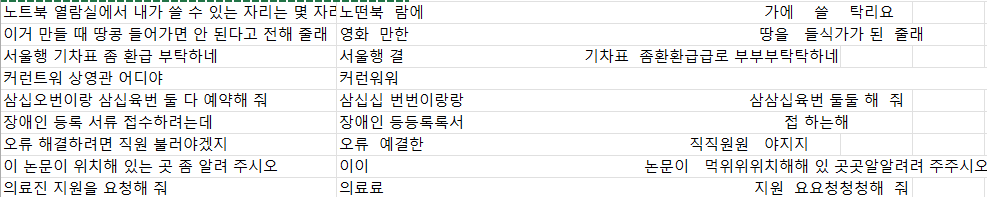

CTC loss의 경우 입력과 출력의 정렬이 불명확해도 이를 고려하여 계산을 하는 반면 CER은 모두 반영하기 때문이다.

# 평가

In [11]:
!python '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/bin/inference_wer.py' --model_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/outputs/2024-05-31/20-11-50/model.pt' --audio_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/test_wav' --transcript_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/testscript/transcripts.txt' --dst_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/result' --device "cpu"

701 files test starts...
CER/WER caculation: True
-> transcript: /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/testscript/transcripts.txt
Output destination: /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/result
701it [04:16,  2.74it/s]
701 files test completed...
Average WER: 0.19944979367262725
Average CER: 0.10394224157689663


Test dataset 702개에 대한 평균 WER, CER을 평가하였다.\
평가 방법은 test dataset에 대한 transcripts를 만들어 예측 문장과 실제 문장을 비교하면서 이루어진다. 해당 파일은 앞선 과정과 동일하게 만들었으며 평가 결과는 result로 저장된다.

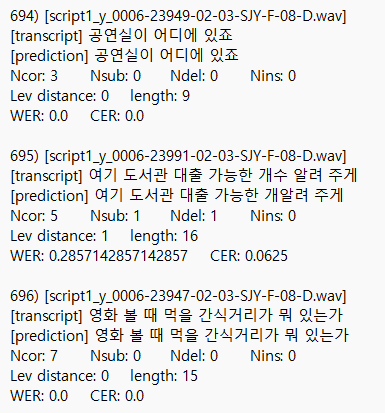

평가가 매우 잘 이루어졌지만 실제로 키오스크가 사용되는 환경은 소음이 많고 노인 분들에 따라 말이 느린 분이 있을 수 있다. 따라서 해당 상황을 고려하여 Speed와 Noise를 조절한 test data에 대해 다시 한번 평가해보고자 한다.

In [ ]:
import numpy as np
import os
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# noise 추가
def add_noise(y, noise_rate=0.001):
    noise = np.random.normal(0, noise_rate, len(y))  # 평균 0, 표준편차 noise_rate
    y_noisy = y + noise
    return y_noisy

# 속도 0.9배로 고정
def speed(y, fixed_rate=0.9):
    speeded_y = librosa.effects.time_stretch(y, rate=fixed_rate)
    return speeded_y

# 메인 처리 함수
def pre_processing_audio(data_path, noise_rate=0.001):
    y, sr = librosa.load(data_path, sr=None)
    y = speed(y, fixed_rate=0.9)
    y = add_noise(y, noise_rate)
    return y, sr

In [42]:
pre_processed_test_dir = '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/pre_processed_test_wav'
test_dir = '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/test_wav'

# 출력 디렉토리 생성
os.makedirs(pre_processed_test_dir, exist_ok=True)

# 각 파일에 대해 전처리 수행 및 저장
for file_name in os.listdir(test_dir):
    if file_name.endswith('.wav'):
        input_data = os.path.join(test_dir, file_name)
        output_data = os.path.join(pre_processed_test_dir, file_name)

        # 오디오 전처리
        y, sr = pre_processing_audio(input_data)

        # 전처리된 오디오 저장
        sf.write(output_data, y, sr)

print("Audio preprocessing completed.")

Audio preprocessing completed.


In [43]:
!python '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/bin/inference_wer.py' --model_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/outputs/2024-05-31/20-11-50/model.pt' --audio_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/pre_processed_test_wav' --transcript_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/testscript/transcripts.txt' --dst_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/result' --device "cpu"

701 files test starts...
CER/WER caculation: True
-> transcript: /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/testscript/transcripts.txt
Output destination: /content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/result
701it [04:13,  2.76it/s]
701 files test completed...
Average WER: 0.27125171939477305
Average CER: 0.1425624570249828


In [23]:
#노이즈 추가 음성 데이터 전사 예측
!python '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/bin/inference.py' --model_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/KoreanSTT/outputs/2024-05-31/20-11-50/model.pt'  --audio_path '/content/drive/MyDrive/2024 3-1 DL/Team_project/SampleData/pre_processed_test_wav/script1_y_0008-23935-02-03-YJY-M-09-A.wav'

이 수술 몇 시쯤 끝나
